In [2]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import sys
sys.path.append(os.path.join(os.getcwd(), "otgnn"))
sys.path.append(os.path.join(os.getcwd(), "molgen"))


%load_ext autoreload
%autoreload 2

/home/octav/gitrepos/tum-thesis


In [3]:
from otgnn.models import GCN
# from molgen.dataloading.MolGraphBatchPreprocessor import MolGraph
from otgnn.graph import MolGraph
from otgnn.utils import save_model, load_model
from otgnn.graph import SYMBOLS, FORMAL_CHARGES, BOND_TYPES


from mol_opt.data_mol_opt import MolOptDataset
from mol_opt.data_mol_opt import get_loader
from mol_opt.arguments import get_args
from mol_opt.train_mol_opt import main
from mol_opt.mol_opt import MolOpt
from mol_opt.decoder_mol_opt import MolOptDecoder
from mol_opt.ot_utils import encode_target

from molgen.dataloading.feat2smiles import feat2smiles
from molgen.dataloading.mol_drawer import MolDrawer
from molgen.metrics.Penalty import Penalty

from rdkit.Chem import MolFromSmiles

import torch
import numpy as np
import time

In [4]:
sys.argv = ["", "-cuda"]
args = get_args()

In [31]:
model = "transformer3"
args.output_dir = f"mol_opt/output_{model}/"
model_iter = 20 

model_name = "model_{}_{}".format(model, model_iter)
model_decode_name = "model_{}_decode_{}".format(model, model_iter)
molopt, config = load_model(args.output_dir + model_name, MolOpt, args.device)
molopt, config

(MolOpt(
   (GCN): GCN(
     (W_message_i): Linear(in_features=100, out_features=50, bias=False)
     (W_message_h): Linear(in_features=50, out_features=50, bias=False)
     (W_message_o): Linear(in_features=143, out_features=50, bias=True)
     (W_mol_h): Linear(in_features=50, out_features=100, bias=True)
     (W_mol_o): Linear(in_features=100, out_features=1, bias=True)
     (dropout_gcn): Dropout(p=0.0, inplace=False)
     (dropout_ffn): Dropout(p=0.0, inplace=False)
   )
   (opt0): Linear(in_features=50, out_features=50, bias=True)
   (opt1): Linear(in_features=50, out_features=50, bias=True)
   (transformer): Encoder(
     (layers): ModuleList(
       (0): EncoderLayer(
         (self_attn): MultiHeadedAttention(
           (linears): ModuleList(
             (0): Linear(in_features=50, out_features=50, bias=True)
             (1): Linear(in_features=50, out_features=50, bias=True)
             (2): Linear(in_features=50, out_features=50, bias=True)
             (3): Linear(in_fe

In [32]:
molopt_decoder, config_decoder = load_model(args.output_dir + model_decode_name, MolOptDecoder, args.device)
molopt_decoder, config_decoder

(MolOptDecoder(
   (fc1_SYMBOLS): Linear(in_features=50, out_features=150, bias=True)
   (fc2_SYMBOLS): Linear(in_features=150, out_features=64, bias=True)
   (fc1_CHARGES): Linear(in_features=50, out_features=150, bias=True)
   (fc2_CHARGES): Linear(in_features=150, out_features=5, bias=True)
   (fc1_BONDS): Linear(in_features=100, out_features=150, bias=True)
   (fc2_BONDS): Linear(in_features=150, out_features=5, bias=True)
 ),
 Namespace(N_transformer=6, agg_func='sum', annealing_rate=0.05, batch_norm=False, connectivity=True, connectivity_hard=False, connectivity_lambda=0.015, cuda=True, device='cuda:0', dim_tangent_space=40, dropout_ffn=0.0, dropout_gcn=0.0, dropout_transformer=0.1, euler_characteristic_penalty=True, euler_lambda=0.2, ffn_activation='LeakyReLU', init_decoder_model='transformer3_decode', init_model='transformer3', linear_out=False, n_epochs=40, n_ffn_hidden=100, n_ffn_transformer=100, n_heads_transformer=10, n_hidden=50, n_labels=1, n_layers=5, ot_solver='emd', ou

In [33]:
train_data_loader = get_loader("iclr19-graph2graph/data/qed", "train", 36, False)
val_data_loader = get_loader("iclr19-graph2graph/data/qed", "val", 36, False)

In [34]:
for i in val_data_loader:
    X = (MolGraph(i[0]))
    Y = (MolGraph(i[1]))
    break

# Assess GCN

In [35]:
x_embedding, x_delta_hat = molopt.forward(X)
y_embedding = molopt.encode(Y)

In [36]:
x_embedding + x_delta_hat

tensor([[-14034.1094,  30467.8008, -12617.5186,  ..., -13085.9600,
          -5950.0015, -20568.1172],
        [-23288.8281,  56320.9922, -23587.1387,  ..., -20332.5371,
         -12388.7598, -41099.5859],
        [ -1618.2581,   7445.7021,  -2588.3606,  ...,  -1419.2861,
          -2162.6577,  -5000.5532],
        ...,
        [ -4015.1821,   6479.9395,  -2585.2725,  ...,  -3823.1790,
           -966.6343,  -4202.3081],
        [ -1591.8644,   6406.6299,  -2128.1655,  ...,  -1897.3630,
          -1712.6937,  -5693.7148],
        [ -3444.7979,   8322.7549,  -3171.5842,  ...,  -3449.8652,
          -1710.2346,  -5099.4810]], device='cuda:0', grad_fn=<AddBackward0>)

In [37]:
y_embedding

tensor([[ -8648.7305,  19538.2402,  -8283.8359,  ...,  -6919.1240,
          -4145.2388, -14376.1123],
        [ -9680.9521,  21479.5996,  -9192.8057,  ...,  -7653.0239,
          -4646.7119, -16672.3594],
        [ -2027.0767,   7860.4878,  -2748.7036,  ...,  -1756.2297,
          -2203.2603,  -5260.8418],
        ...,
        [ -6825.0347,  15518.2402,  -6686.8237,  ...,  -5087.0645,
          -3407.0793, -11966.9229],
        [ -1542.5999,   5864.0396,  -1777.1814,  ...,   -927.2489,
          -2016.9915,  -6771.3062],
        [ -4700.9707,  10143.4863,  -4106.1602,  ...,  -3869.6885,
          -2163.7881,  -7384.1899]], device='cuda:0', grad_fn=<CopySlices>)

In [38]:
x_embedding

tensor([[-14033.8906,  30467.6895, -12617.6221,  ..., -13085.1973,
          -5950.3506, -20568.0586],
        [-23288.6406,  56321.0156, -23587.1562,  ..., -20331.7695,
         -12388.7539, -41099.5312],
        [ -1617.7802,   7445.6719,  -2588.6777,  ...,  -1420.3020,
          -2162.3589,  -5000.4614],
        ...,
        [ -4015.1523,   6479.8931,  -2585.4087,  ...,  -3823.0508,
           -966.8394,  -4202.2607],
        [ -1591.7032,   6406.5928,  -2127.9678,  ...,  -1897.0835,
          -1713.5751,  -5693.7476],
        [ -3444.7668,   8322.6973,  -3171.4155,  ...,  -3449.6187,
          -1710.3260,  -5099.4272]], device='cuda:0', grad_fn=<CopySlices>)

In [39]:
x_delta_hat

tensor([[-0.2192,  0.1119,  0.1033,  ..., -0.7629,  0.3493, -0.0577],
        [-0.1874, -0.0227,  0.0176,  ..., -0.7673, -0.0058, -0.0530],
        [-0.4779,  0.0305,  0.3172,  ...,  1.0159, -0.2987, -0.0918],
        ...,
        [-0.0299,  0.0465,  0.1362,  ..., -0.1281,  0.2051, -0.0473],
        [-0.1611,  0.0372, -0.1979,  ..., -0.2795,  0.8814,  0.0326],
        [-0.0311,  0.0575, -0.1686,  ..., -0.2466,  0.0914, -0.0538]],
       device='cuda:0', grad_fn=<AddBackward0>)

# Run all model, get some predictions

In [40]:
for idx, i in enumerate(val_data_loader):
    if idx == 1:
        X = (MolGraph(i[0]))
        Y = (MolGraph(i[1]))
        break

In [41]:
x_embedding, yhat_embedding = molopt.forward(X)
results_logits = molopt_decoder.forward(yhat_embedding,X, Y)
results_labels = molopt_decoder.discretize(*results_logits)

In [42]:
symbols_logits, charges_logits, bonds_logits = results_logits
symbols_labels, charges_labels, bonds_labels = results_labels

In [43]:
symbols_logits

tensor([[   3.8535,    0.1123,    1.6204,  ...,  -59.0070,  -53.7231,
          -43.3518],
        [   9.0667,    2.9349,   -0.1396,  ...,  -89.3130, -102.3104,
          -96.1684],
        [   3.2205,    1.7737,   -2.4507,  ...,  -45.7750,  -42.5477,
          -48.9054],
        ...,
        [   6.9941,    4.2163,   -2.3420,  ...,  -58.5781,  -71.0286,
          -76.7195],
        [   6.4561,    4.2429,   -2.7559,  ...,  -48.4871,  -65.9467,
          -73.3959],
        [  12.7956,    5.2891,   -7.2100,  ...,  -67.1479,  -62.1670,
          -66.6043]], device='cuda:0', grad_fn=<CatBackward>)

In [44]:
yhat_embedding

tensor([[ 0.6232,  0.0368, -0.2047,  ..., -0.5678, -0.1348,  0.0403],
        [-0.2049,  0.1051,  0.3493,  ..., -0.5382,  0.3138, -0.0542],
        [-0.1093,  0.0850, -0.2261,  ..., -0.3169, -0.1054, -0.0252],
        ...,
        [-0.1159, -0.2298, -0.1612,  ...,  0.2253,  0.1958, -0.0576],
        [ 1.3990,  0.0797, -0.2285,  ..., -0.6823,  0.4944, -0.0675],
        [-0.3730, -0.4296,  0.1724,  ..., -0.5612,  0.0478, -0.0605]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [45]:
bonds_logits

tensor([[ -0.5755,  -4.7060, -14.0697,  -5.1360,   1.9553],
        [ -0.5136,  -4.7823, -13.1014,  -4.5467,   1.9868],
        [ -0.5294,  -4.7136, -13.0713,  -4.5905,   1.9841],
        ...,
        [ -0.4889,  -4.9397, -12.6265,  -4.7691,   1.9450],
        [ -0.5307,  -4.7546, -12.6583,  -4.6815,   1.9726],
        [ -0.3325,  -7.3052, -11.1962,  -6.7119,   1.9668]], device='cuda:0',
       grad_fn=<CatBackward>)

In [46]:
bonds_labels_arr = bonds_labels.cpu().numpy()

In [47]:
np.unique(bonds_labels_arr, return_counts=True)

(array([4]), array([19753]))

In [48]:
target_symbols, target_bonds = encode_target(Y)
target_charges = target_symbols
target_symbols_labels, target_charges_labels, target_bonds_labels = molopt_decoder.discretize(target_symbols, target_charges, target_bonds)

In [49]:
print (np.unique(target_symbols_labels.cpu().numpy(), return_counts=True))
print (np.unique(symbols_labels.cpu().numpy(), return_counts=True))

(array([0, 1, 2, 3, 4, 7, 8]), array([601,  89,  74,  10,   6,   2,   4]))
(array([0, 1, 2, 3]), array([719,  79,  17,  20]))


In [50]:
print (np.unique(target_bonds_labels.cpu().numpy(), return_counts=True))
print (np.unique(bonds_labels.cpu().numpy(), return_counts=True))

(array([0, 1, 4]), array([ 1272,   432, 15644]))
(array([4]), array([19753]))


In [126]:
bonds_logits.shape

torch.Size([17348, 5])

In [127]:
lex = Y.scope[0][1]
bonds_logits.narrow(0,0,lex ** 2).view(lex, lex, 5)[:,:,0]

tensor([[-0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050,
         -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050,
         -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050],
        [-0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050,
         -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050,
         -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050],
        [-0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050,
         -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050,
         -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050],
        [-0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050,
         -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050,
         -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050, -0.5050],
        [-0.5050, -0.505

In [128]:
symbols_labels

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2,
        0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 3,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 3, 1, 0, 0, 1, 0, 0, 0,

In [86]:
os.getcwd()

'/home/octav/gitrepos/tum-thesis'

In [135]:
y = X.get_graph_outputs()

# Visualize

In [26]:
from tensorboardX import SummaryWriter
tb_writer = SummaryWriter(logdir = f"mol_opt/logs_{model}")

mol_drawer = MolDrawer(tb_writer, SYMBOLS, BOND_TYPES, FORMAL_CHARGES)

In [27]:
#preprocess
from rdkit import Chem
initial_smiles = [Chem.MolToSmiles(x) for x in X.rd_mols]
target_smiles = [Chem.MolToSmiles(y) for y in Y.rd_mols]

labels = (symbols_labels, charges_labels, bonds_labels)
# labels = (target_symbols_labels, target_charges_labels, target_bonds_labels)
prediction = (labels, None, Y.scope)

In [138]:
symbols_labels.shape

torch.Size([786])

In [139]:
sum([y for _, y in Y.scope])

786

In [143]:
mol_drawer.visualize_batch(prediction, target_smiles, 17, None, text = "transformer3_manual_")

In [35]:
bond_idx = 1
for idx, (stx, lex) in enumerate(Y.scope):
    dev_sym = prediction[0][0].narrow(0, stx, lex).cpu().numpy()
    np.savetxt('symbols.txt', dev_sym, fmt='%i')
    np.savetxt('charges.txt', prediction[0][1].narrow(0, stx, lex).cpu().numpy(), fmt='%i')
    
    dev_bnd = prediction[0][2].narrow(0, bond_idx, lex*lex).view(lex, lex).cpu().numpy()
    np.savetxt('bonds.txt', dev_bnd, fmt='%i')
    bond_idx += lex * lex
    
    if idx == 0:
        break

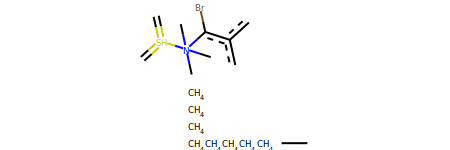

In [47]:
smiles = "C.C.C.C.C.C.C.C=S(=C)(=C)N(C)(C)(C)c(Br)c(c)c.CC"
smiles = "C.C.C.C.C.C.C.C.C=[SH](=C)N(C)(C)(C)c(Br)c(c)c.CC"
from rdkit import Chem

from rdkit.Chem.Draw import IPythonConsole
Chem.MolFromSmiles(smiles, sanitize = False)

In [48]:
# Chem.MolFromSmiles("C.C.C.C.C.C.C.C.C=[SH](=C)N(C)(C)(C)c(Br)c(c)c.CC")

In [49]:
smiles

'C.C.C.C.C.C.C.C.C=[SH](=C)N(C)(C)(C)c(Br)c(c)c.CC'

In [50]:
bonds_labels

tensor([4, 4, 0,  ..., 4, 4, 4], device='cuda:0', grad_fn=<NotImplemented>)

In [51]:
dev_sym

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0])

In [52]:
mol = feat2smiles(SYMBOLS,None,BOND_TYPES,dev_sym, None, dev_bnd)

In [59]:
mol

'C.C.C.C.C.C.C.C.C.C1CCC1.C=C.CCCC.CCO'

# Validity

In [68]:
from molgen.metrics.mol_metrics import MolMetrics
metrics = MolMetrics(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, False)

target = Y.get_graph_outputs()

In [83]:
metrics.batch_molecular_disconnected_validity(prediction, target)
metrics.batch_molecular_validity(prediction, target)
metrics.batch_symbol_accuracy(prediction, target)
metrics.batch_connected_components(prediction, target)
metrics.batch_invalid_valency_nodes(prediction, target)

100.0

In [80]:
feat2smiles()

TypeError: feat2smiles() missing 6 required positional arguments: 'SYMBOLS', 'FORMAL_CHARGES', 'BOND_TYPES', 'symbols', 'charges', and 'bonds'

In [70]:
target

array([{'SYMBOLS': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]), 'FORMAL_CHARGES': tensor([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]]), 'BOND_TYPES': tensor([[[0., 0., 0., 0., 1.],
 

In [207]:
molopt.ref

tensor([[-1.2517,  0.4915, -1.9540,  ..., -0.4416,  1.1475, -1.9537],
        [-0.2895,  0.4184,  0.2665,  ..., -2.4453, -0.5888,  0.2592],
        [-0.3932, -0.6139,  0.9896,  ..., -0.4043,  1.3791, -1.6461],
        ...,
        [ 1.2792,  0.6248, -1.1144,  ...,  0.5200,  0.0337, -0.4816],
        [-0.9822,  0.5073, -0.6295,  ..., -1.6160, -0.6144, -0.7320],
        [ 0.3101,  0.2944, -0.4003,  ..., -1.0795, -0.3007,  0.0121]],
       device='cuda:0', requires_grad=True)

In [57]:
ft = {
    "SYMBOLS" : SYMBOLS,
    "BOND_TYPES" : BOND_TYPES,
    "FORMAL_CHARGES" : FORMAL_CHARGES
}
Penalty(ft)

In [58]:
BOND_TYPES

[rdkit.Chem.rdchem.BondType.SINGLE,
 rdkit.Chem.rdchem.BondType.DOUBLE,
 rdkit.Chem.rdchem.BondType.TRIPLE,
 rdkit.Chem.rdchem.BondType.AROMATIC,
 None]

# Debug bonds

In [51]:
x_batch = Y
from mol_opt.ot_utils import compute_barycenter
import torch.nn.functional as F
from mol_opt.decoder_mol_opt import n_SYMBOLS, n_FORMAL_CHARGES, n_BOND_TYPES

In [52]:
molopt_decoder

MolOptDecoder(
  (fc1_SYMBOLS): Linear(in_features=50, out_features=150, bias=True)
  (fc2_SYMBOLS): Linear(in_features=150, out_features=64, bias=True)
  (fc1_CHARGES): Linear(in_features=50, out_features=150, bias=True)
  (fc2_CHARGES): Linear(in_features=150, out_features=5, bias=True)
  (fc1_BONDS): Linear(in_features=100, out_features=150, bias=True)
  (fc2_BONDS): Linear(in_features=150, out_features=5, bias=True)
)

In [53]:
bonds_logits = torch.empty(0, n_BOND_TYPES, device=args.device)
symbols_logits = torch.empty(0, n_SYMBOLS, device=args.device)
charges_logits = torch.empty(0, n_FORMAL_CHARGES, device=args.device)

for idx, (stx, lex) in enumerate(x_batch.scope):
    # x_narrow = x_embedding.narrow(0, stx, lex)
    x_narrow = yhat_embedding.narrow(0, idx*molopt_decoder.Nref, molopt_decoder.Nref)
    # cheating a bit here, by looking at what # of atoms should be
    x_narrow_resized = compute_barycenter(x_narrow, lex)

    symbols_logits_mol = molopt_decoder.fc2_SYMBOLS(F.relu(molopt_decoder.fc1_SYMBOLS(x_narrow_resized)))
    symbols_logits_mol = symbols_logits_mol.view(-1, n_SYMBOLS)
    symbols_logits = torch.cat((symbols_logits, symbols_logits_mol))

    charges_logits_mol = molopt_decoder.fc2_CHARGES(F.relu(molopt_decoder.fc1_CHARGES(x_narrow_resized)))
    charges_logits_mol = charges_logits_mol.view(-1, n_FORMAL_CHARGES)
    charges_logits = torch.cat((charges_logits, charges_logits_mol))

    x1 = x_narrow_resized.view(lex, 1, -1).repeat(1, lex, 1)
    x2 = x_narrow_resized.view(1, lex, -1).repeat(lex, 1, 1)
    _bonds = torch.cat((x1, x2), dim = 2)
    bonds_logits_mol = molopt_decoder.fc2_BONDS(F.relu(molopt_decoder.fc1_BONDS(_bonds)))
    break
    # add matrix with its transpose, to get the 
    bonds_logits_mol = bonds_logits_mol.view(lex, lex, n_BOND_TYPES) 
    bonds_logits_mol = bonds_logits_mol + bonds_logits_mol.permute(1,0,2) 
    bonds_logits_mol = bonds_logits_mol.view(-1, n_BOND_TYPES)
    bonds_logits = torch.cat((bonds_logits, bonds_logits_mol))
    
    break

In [54]:
bonds_logits_mol[:,:,0].unique()

tensor([-0.5437, -0.5315, -0.4933, -0.4820, -0.4497, -0.4331, -0.4298, -0.4223,
        -0.4150, -0.4144, -0.4042, -0.4038, -0.4023, -0.3936, -0.3852, -0.3835,
        -0.3831, -0.3809, -0.3771, -0.3752, -0.3737, -0.3680, -0.3640, -0.3584,
        -0.3567, -0.3549, -0.3529, -0.3516, -0.3497, -0.3490, -0.3460, -0.3432,
        -0.3380, -0.3350, -0.3315, -0.3308, -0.3256, -0.3246, -0.3240, -0.3233,
        -0.3207, -0.3176, -0.3175, -0.3174, -0.3159, -0.3154, -0.3149, -0.3121,
        -0.3107, -0.3101, -0.3094, -0.3087, -0.3085, -0.3084, -0.3079, -0.3072,
        -0.3069, -0.3052, -0.3039, -0.3033, -0.3026, -0.3005, -0.3004, -0.2973,
        -0.2968, -0.2962, -0.2959, -0.2955, -0.2948, -0.2946, -0.2942, -0.2938,
        -0.2930, -0.2927, -0.2927, -0.2913, -0.2905, -0.2901, -0.2895, -0.2892,
        -0.2887, -0.2886, -0.2869, -0.2869, -0.2861, -0.2858, -0.2855, -0.2855,
        -0.2853, -0.2851, -0.2849, -0.2848, -0.2845, -0.2842, -0.2842, -0.2840,
        -0.2840, -0.2835, -0.2834, -0.28

In [56]:
bonds_logits_mol

tensor([[[-0.2629, -2.3025, -5.6143, -2.4122,  0.9798],
         [-0.2664, -2.2360, -5.3847, -2.4509,  0.9867],
         [-0.2855, -2.2935, -5.5975, -2.3665,  1.0033],
         ...,
         [-0.2599, -2.3605, -5.8150, -2.3784,  0.9738],
         [-0.2599, -2.3605, -5.8150, -2.3784,  0.9738],
         [-0.2599, -2.3605, -5.8150, -2.3784,  0.9738]],

        [[-0.2599, -2.3605, -5.8150, -2.3784,  0.9738],
         [-0.2599, -2.3605, -5.8150, -2.3784,  0.9738],
         [-0.3004, -2.3508, -5.8120, -2.2883,  1.0137],
         ...,
         [-0.2599, -2.3605, -5.8150, -2.3784,  0.9738],
         [-0.2614, -2.3603, -5.8151, -2.3753,  0.9753],
         [-0.2599, -2.3605, -5.8150, -2.3784,  0.9738]],

        [[-0.3240, -2.3496, -5.8177, -2.2384,  1.0399],
         [-0.3315, -2.3293, -5.7859, -2.2099,  1.0352],
         [-0.5315, -2.3191, -5.6860, -1.8104,  1.2283],
         ...,
         [-0.2808, -2.3300, -5.7705, -2.3156,  0.9777],
         [-0.3737, -2.2224, -5.8556, -2.1628,  1.0641],
  

In [25]:
F.leaky_relu(molopt_decoder.fc1_BONDS(_bonds))

tensor([[[-9.3126e-03, -2.4679e-02, -9.1428e-02,  ..., -2.8695e-02,
          -5.6244e-02, -4.3308e-02],
         [-4.3658e-03, -2.6948e-02, -8.6410e-02,  ..., -2.5767e-02,
          -4.3359e-02, -3.9379e-02],
         [-9.4858e-03, -2.8280e-02, -7.1100e-02,  ..., -3.0318e-02,
          -4.9335e-02, -3.3717e-02],
         ...,
         [-8.5841e-03, -1.9439e-02, -6.8173e-02,  ..., -1.6878e-02,
          -5.5397e-02, -3.2684e-02],
         [-1.0463e-02, -2.3035e-02, -7.3618e-02,  ..., -2.2310e-02,
          -4.7110e-02, -3.5399e-02],
         [-8.5177e-03, -3.2257e-02, -7.2975e-02,  ..., -2.0735e-02,
          -4.6386e-02, -4.5100e-02]],

        [[-7.4890e-03, -2.7750e-02, -8.0326e-02,  ..., -1.1008e-03,
          -4.0692e-02, -3.8185e-02],
         [-2.5422e-03, -3.0019e-02, -7.5308e-02,  ...,  1.8275e-01,
          -2.7807e-02, -3.4257e-02],
         [-7.6622e-03, -3.1352e-02, -5.9998e-02,  ..., -2.7238e-03,
          -3.3784e-02, -2.8594e-02],
         ...,
         [-6.7605e-03, -2

In [212]:
F.leaky_relu

<function torch.nn.functional.leaky_relu(input, negative_slope=0.01, inplace=False)>

In [209]:
list(molopt_decoder.fc1_BONDS.parameters())

[Parameter containing:
 tensor([[ 0.0212,  0.0551,  0.0952,  ..., -0.0505, -0.0010, -0.0275],
         [ 0.0026,  0.0151,  0.0127,  ...,  0.1711, -0.1787,  0.0684],
         [-0.2335,  0.3617, -0.1541,  ...,  0.6596,  0.0088,  0.5311],
         ...,
         [-0.0260, -0.0118, -0.0401,  ...,  0.0668, -0.0403,  0.1360],
         [-0.0839,  0.1181, -0.0512,  ..., -0.0442, -0.0875, -0.0311],
         [ 0.0871,  0.3638,  0.0892,  ...,  0.2207,  0.2458,  0.1275]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0444,  0.0014, -0.4464, -0.0447, -0.6545, -0.2617, -0.0996, -0.3990,
         -0.0043,  0.0018,  0.0261, -0.0301, -0.0837, -0.0293, -0.2843, -0.0361,
         -0.3253, -0.2612, -0.0728, -0.0763,  0.0193, -0.0442, -0.0263,  0.0269,
          0.0377, -0.0588, -0.3579, -0.6008, -0.0597, -0.3481, -0.4315, -0.1658,
         -0.5121, -0.1037, -0.1330, -0.5824, -0.1763, -0.0988, -0.4013, -0.3156,
         -0.0927, -0.2463, -0.1229, -0.3082, -0.0704,  0.0160,